In [ ]:
# locally
import os
import sys


sys.path.append(os.path.dirname(os.path.dirname(__file__)))

In [1]:
# on Kaggle
import sys
sys.path.append('/kaggle/input/gan-training')

In [2]:
import torch

In [3]:
DATA_DIR = 'data_demo'

# Обучение Wasserstein GAN на наборе данных результатов физического эксперимента (условная генерация)

Загрузим данные ([ссылка](https://disk.yandex.ru/d/hcnBVM-FbKdwEQ))

In [4]:
!(mkdir 'data_demo'; \
  curl 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key=https://disk.yandex.ru/d/hcnBVM-FbKdwEQ' | \
  jq '.href' | \
  xargs wget --output-document 'data_demo/caloGAN_case11_5D_120K.npz')

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   604  100   604    0     0    690      0 --:--:-- --:--:-- --:--:--   690
--2023-05-06 10:47:59--  https://downloader.disk.yandex.ru/disk/cd850791102cac87642a4d72cfdd198dbbb0f55dd56ee4a3c3488ef8caf649cc/6456689f/fKqInKw3d7bLFOeFnMGnhHiJTVPTIyntlHTyk3qEVgRsM0aUgIAUoEGbuD_mMptUq1_4fVXwyBXgkN8b4iw3Y8s_Ws2EJSngnAl3J2wKHq2r8npumZHI4midPdWhecNq?uid=0&filename=caloGAN_case11_5D_120K.npz&disposition=attachment&hash=PMIc5HhzoL9c0b%2B4Dp36LSMz76C5W9%2BxXVTTWXFCckAyH6v8mM31aqCrVkc0Arwblsg4VIaLrfRKbQetv4dueQ%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=1130000058986029&fsize=159853022&hid=67819afdcf522536b5a0b9f89a40eac2&media_type=compressed&tknv=v2
Resolving downloader.disk.yandex.ru (downloader.disk.yandex.ru)... 77.88.21.127, 2a02:6b8:

In [5]:
from pipeline.data import get_physics_dataset, UnifiedDatasetWrapper


def form_dataset(train: bool = False) -> torch.utils.data.Dataset:
    data_filepath = DATA_DIR + '/caloGAN_case11_5D_120K.npz'
    return UnifiedDatasetWrapper(get_physics_dataset(data_filepath, train=train))

In [6]:
train_dataset = form_dataset(True)

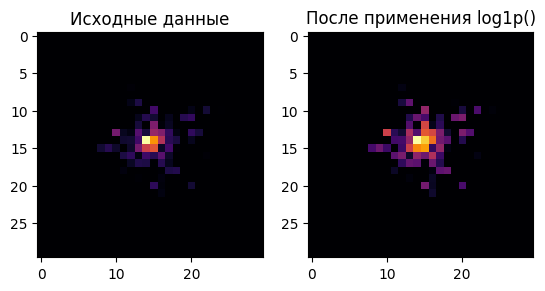

In [7]:
from matplotlib import pyplot as plt

from visualization_aux.visualize_physics import energy_imshow


fig, axs = plt.subplots(1, 2)

axs[0].set_title('Исходные данные')
energy_imshow(train_dataset[0][0], ax=axs[0], log_transform=False)

axs[1].set_title('После применения log1p()')
energy_imshow(train_dataset[0][0], ax=axs[1], log_transform=True)

plt.show()

Задаём метрики, вычисляемые во время обучения

In [8]:
from pipeline.metrics import CriticValuesDistributionMetric, Metric, MetricsSequence, PHYS_STATISTICS, PhysicsDataStatistics
from pipeline.custom_metrics import *


def form_metric() -> Metric:
    return MetricsSequence(
        CriticValuesDistributionMetric(values_cnt=1000),
        PhysicsDataStatistics(
            *[statistic_cls() for statistic_cls in PHYS_STATISTICS],
            create_prd_energy_embed(),
            create_conditional_prd_energy_embed(),
            create_prd_physics_statistics(),
            create_conditional_prd_physics_statistics(),
        ),
    )

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Зададим предикат вычисления метрик, чтобы не вычислять их на каждой эпохе, т.к. это требует большого (относительно обучения) времени

In [9]:
from pipeline.predicates import TrainPredicate, IgnoreFirstNEpochsPredicate, EachNthEpochPredicate


def form_metric_predicate() -> TrainPredicate:
    # начиная с 10-й эпохи, метрики будут вычисляться на каждой 5-ой
    return IgnoreFirstNEpochsPredicate(9) & EachNthEpochPredicate(5)

Зададим логирование в WandB (чтобы повторить локально, небходимо задать переменную окружения `WANDB_TOKEN`)

In [10]:
import contextlib

from pipeline.wandb_logger import WandbCM


def init_logger(model_name: str):
    project_name = 'GAN_DEMO'
    @contextlib.contextmanager
    def logger_cm():
        try:
            with WandbCM(project_name=project_name, experiment_id=model_name) as wandb_logger:
                yield wandb_logger
        finally:
            pass
    return logger_cm

Зададим хранилище промежуточных состояний обучаемых моделей

In [11]:
from pipeline.storage import ExperimentsStorage


def init_storage() -> ExperimentsStorage:
    # === config variables ===
    experiments_dir = './experiments'
    checkpoint_filename = './training_checkpoint'
    model_state_filename = './model_state'
    # ========================
    return ExperimentsStorage(experiments_dir=experiments_dir, checkpoint_filename=checkpoint_filename,
                              model_state_filename=model_state_filename)

In [12]:
experiments_storage = init_storage()

Зададим гиперпараметры обучения

In [13]:
from typing import Generator, Tuple

from pipeline.discriminators import CaloganPhysicsDiscriminator
from pipeline.gan import GAN
from pipeline.generators import CaloganPhysicsGenerator
from pipeline.normalization import apply_normalization, SpectralNormalizer
from pipeline.train import GanTrainer, Stepper, WganEpochTrainer


def form_gan_trainer(model_name: str, n_epochs: int) -> Generator[Tuple[int, GAN], None, GAN]:
    logger_cm_fn = init_logger(model_name)
    metric = form_metric()
    metric_predicate = form_metric_predicate()
    
    train_dataset = form_dataset(True)
    val_dataset = form_dataset(False)
    
    # зададим шум как вектор размерности 50
    noise_dimension = 50

    def uniform_noise_generator(n: int) -> torch.Tensor:
        return 2*torch.rand(size=(n, noise_dimension)) - 1  # [-1, 1]
    
    # используем готовые архитектуры моделей генератора и дискриминатора
    generator = CaloganPhysicsGenerator(noise_dim=noise_dimension)
    discriminator = CaloganPhysicsDiscriminator()
    
    # применим спектральную нормализацию к дискриминатору
    discriminator = apply_normalization(discriminator, SpectralNormalizer)
    
    gan_model = GAN(generator, discriminator, uniform_noise_generator)
    
    # зададим оптимизаторы
    generator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(generator.parameters(), lr=1e-3)
    )

    discriminator_stepper = Stepper(
        optimizer=torch.optim.RMSprop(discriminator.parameters(), lr=1e-5)
    )
    
    # trainer для одной эпохи, используем Wasserstein GAN
    epoch_trainer = WganEpochTrainer(n_critic=5, batch_size=100)
    
    # теперь зададим trainer для всего процесса обучения
    # будем сохранять модели каждые 10 эпох и загружать состояние, если оно имеется
    model_dir = experiments_storage.get_model_dir(model_name)
    trainer = GanTrainer(model_dir=model_dir, use_saved_checkpoint=True, save_checkpoint_once_in_epoch=10)
    train_gan_generator = trainer.train(gan_model=gan_model,
                                        train_dataset=train_dataset, val_dataset=val_dataset,
                                        generator_stepper=generator_stepper,
                                        critic_stepper=discriminator_stepper,
                                        epoch_trainer=epoch_trainer,
                                        n_epochs=n_epochs,
                                        metric=metric,
                                        metric_predicate=metric_predicate,
                                        logger_cm_fn=logger_cm_fn)
    
    return train_gan_generator

In [14]:
gan_trainer = form_gan_trainer(model_name='physics demo', n_epochs=50)

In [15]:
from visualization_aux.visualize_physics import get_test_data
from pipeline.config import GlobalConfig, PathsConfig
from pipeline.device import get_local_device


global_config = GlobalConfig(paths=PathsConfig(DATA_DIR, './experiments'), logger=None)
# отобранные вручную объекты датасеты с разными условиями
visualization_data = get_test_data(global_config)
visualization_data = (visualization_data[0], visualization_data[1][:5].to(get_local_device()), visualization_data[2][:5].to(get_local_device()))

In [16]:
from visualization_aux.common import gen_several_images

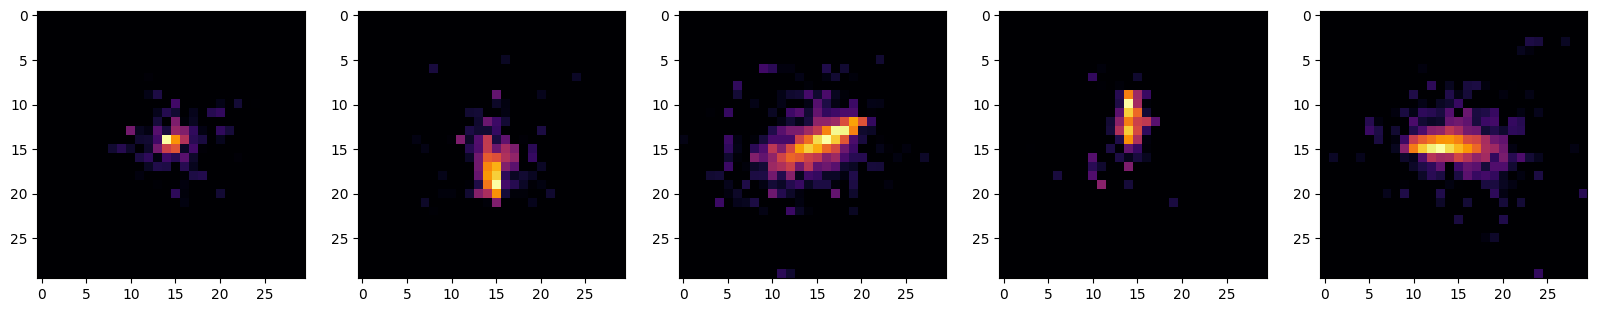

In [18]:
# истинные значения для выбранных условий
fig, axs = plt.subplots(1, len(visualization_data[0]), figsize=(20, 5))

for ax, x in zip(axs, visualization_data[0]):
    energy_imshow(energy=torch.Tensor(x).permute(2, 0, 1), ax=ax)

plt.show()

Запустим обучение (если доступна CUDA, то для обучения будет использоваться GPU)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: trickman. Use `wandb login --relogin` to force relogin


100%|██████████| 600/600 [00:53<00:00, 11.26it/s]


epochs done: 1


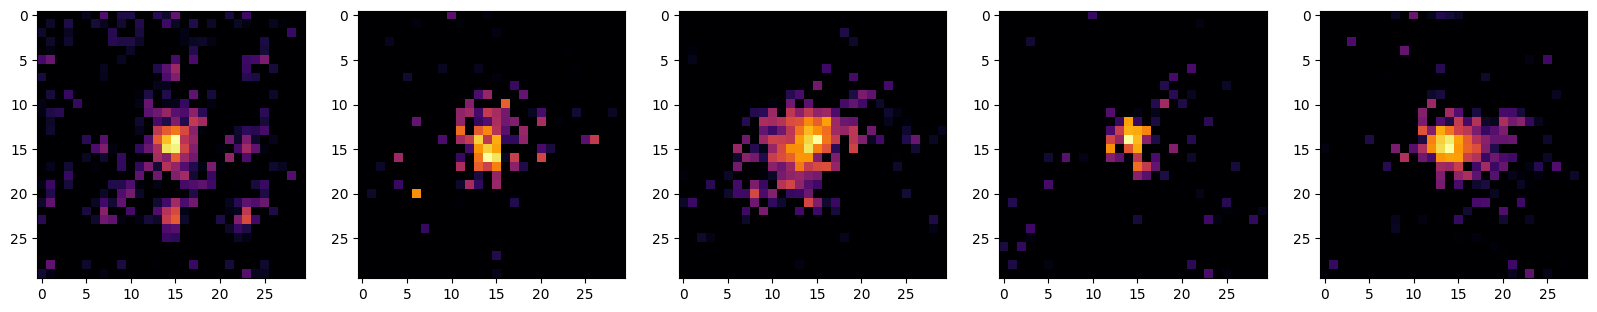

100%|██████████| 600/600 [00:46<00:00, 13.03it/s]


epochs done: 2


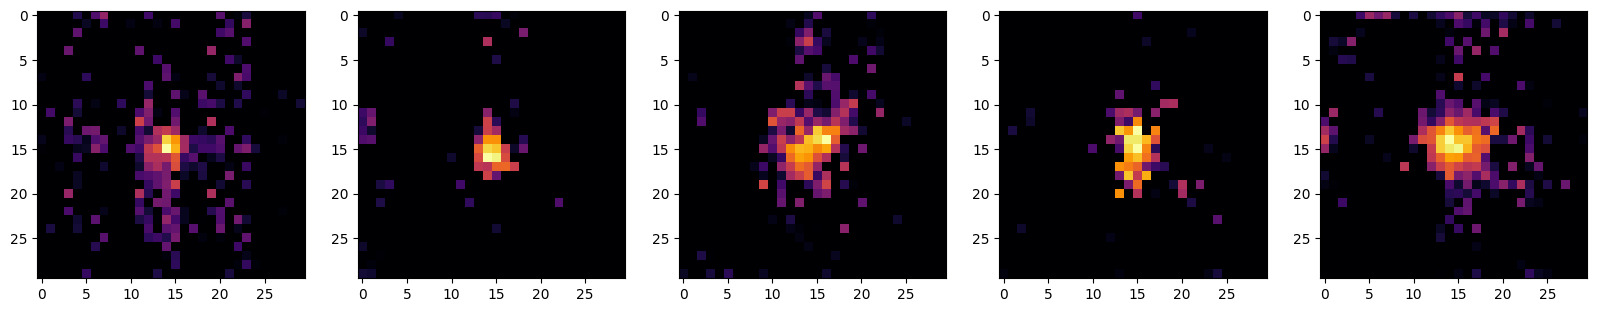

100%|██████████| 600/600 [00:46<00:00, 13.03it/s]


epochs done: 3


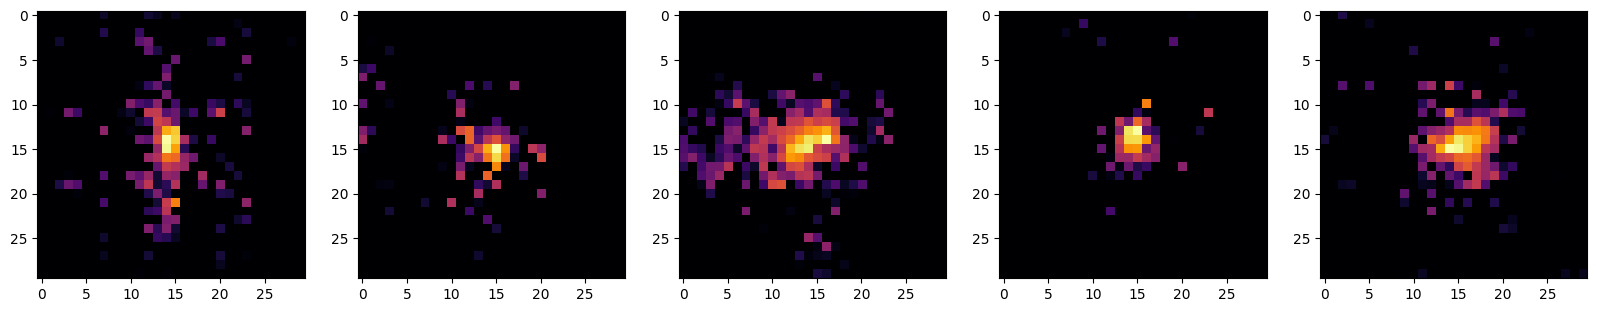

100%|██████████| 600/600 [00:46<00:00, 12.96it/s]


epochs done: 4


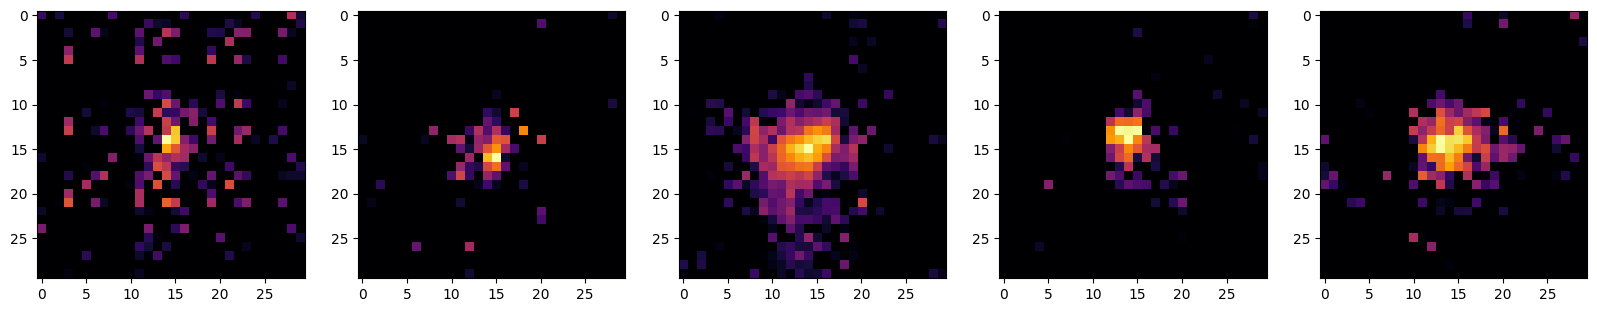

100%|██████████| 600/600 [00:46<00:00, 13.02it/s]


epochs done: 5


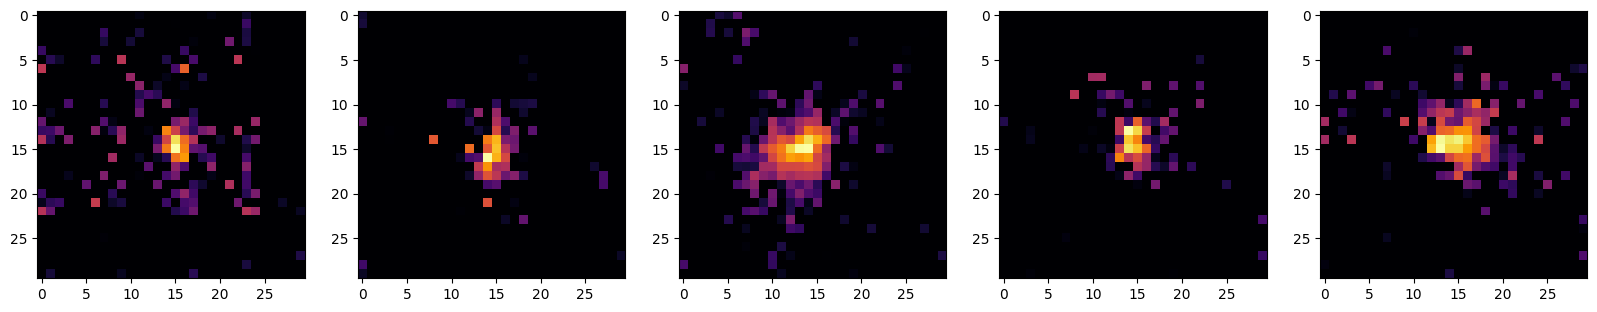

100%|██████████| 600/600 [00:46<00:00, 12.99it/s]


epochs done: 6


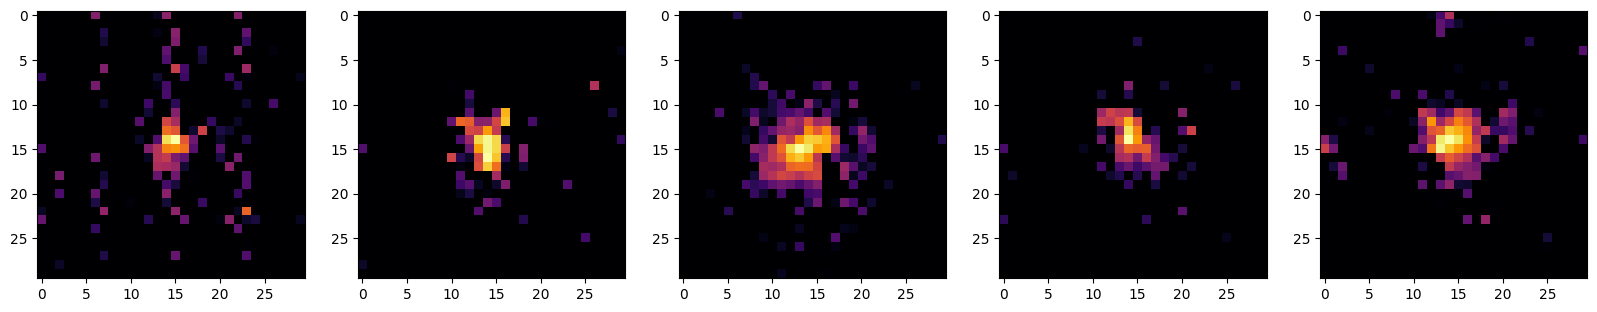

100%|██████████| 600/600 [00:45<00:00, 13.14it/s]


epochs done: 7


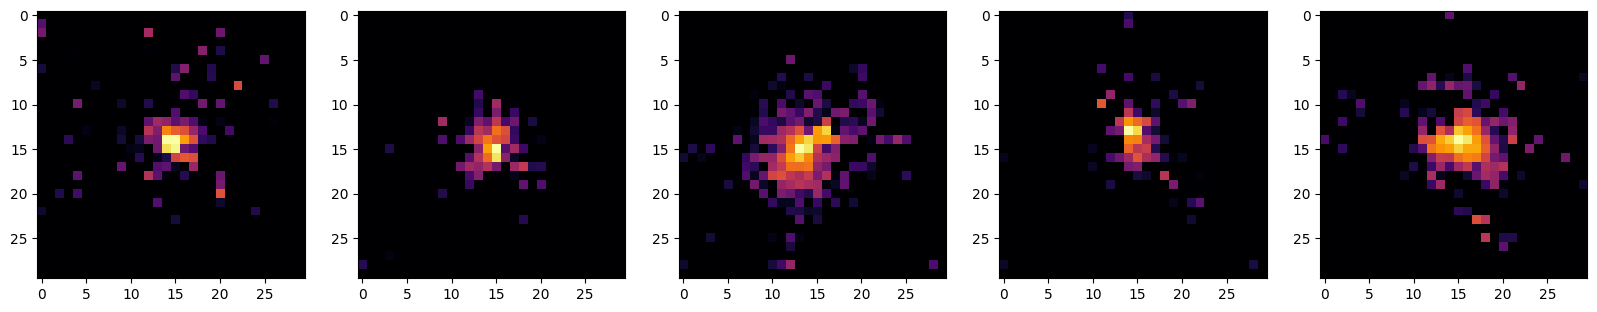

100%|██████████| 600/600 [00:45<00:00, 13.09it/s]


epochs done: 8


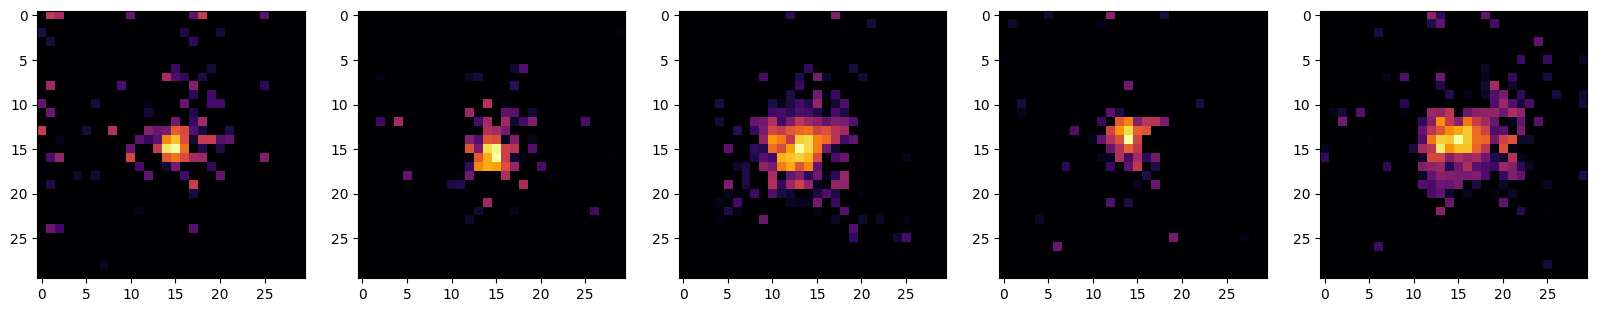

100%|██████████| 600/600 [00:45<00:00, 13.22it/s]


epochs done: 9


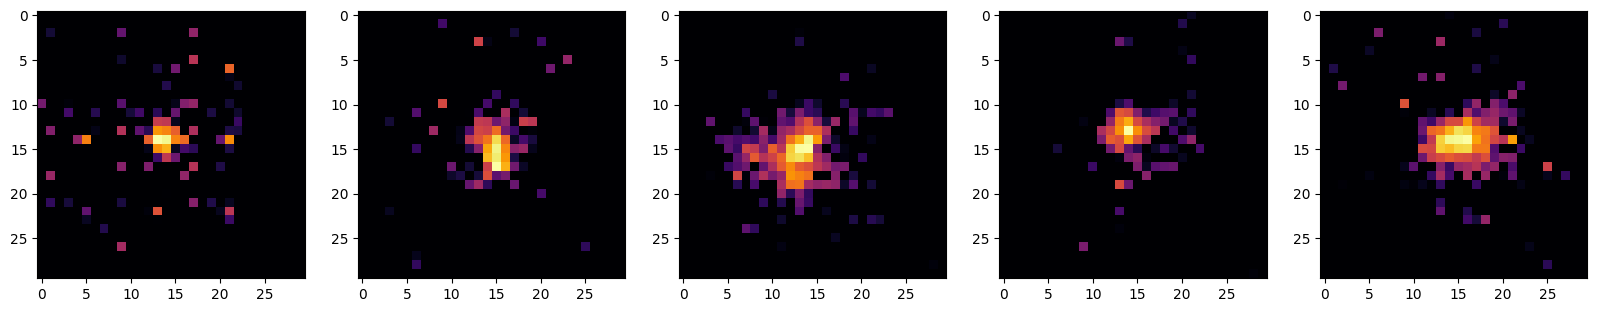

100%|██████████| 9/9 [01:33<00:00, 10.34s/it]


epochs done: 10


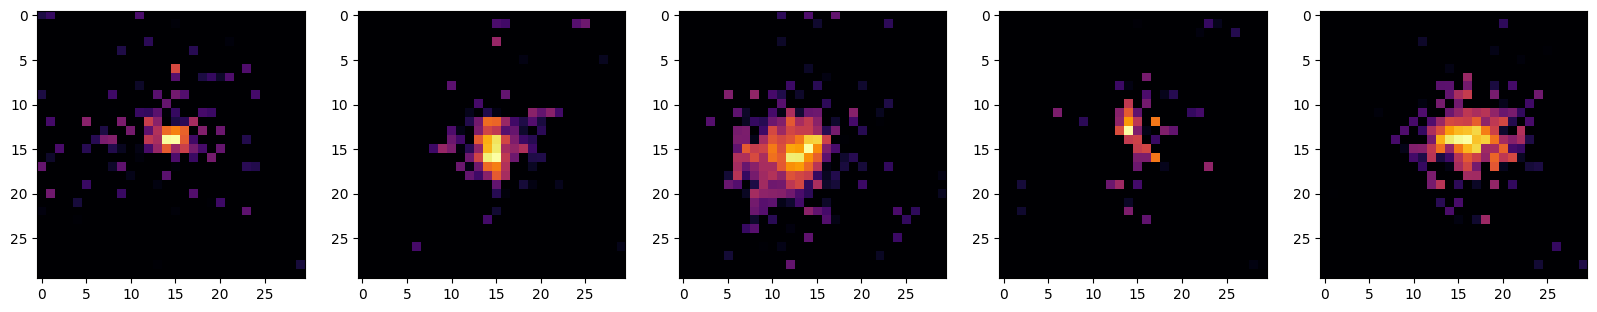

100%|██████████| 600/600 [00:46<00:00, 13.03it/s]


epochs done: 11


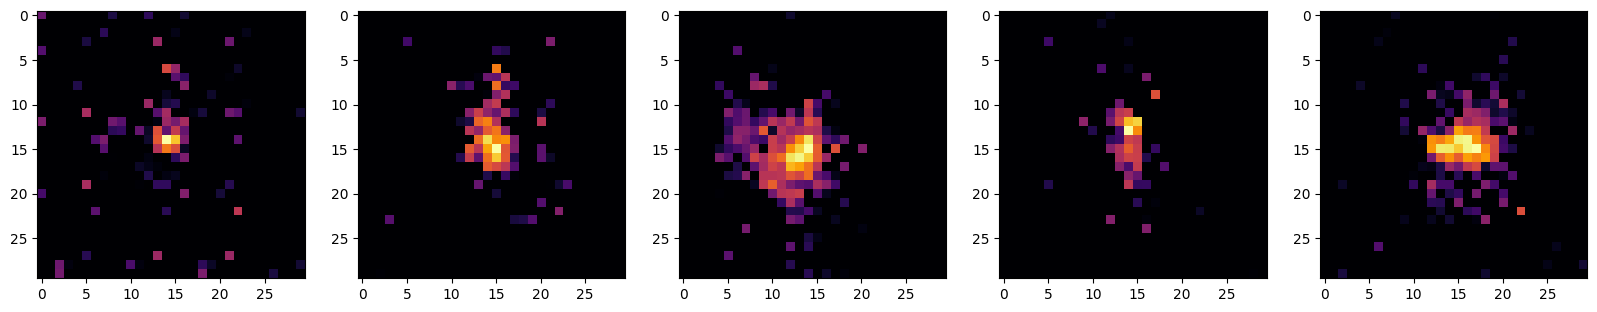

100%|██████████| 600/600 [00:45<00:00, 13.14it/s]


epochs done: 12


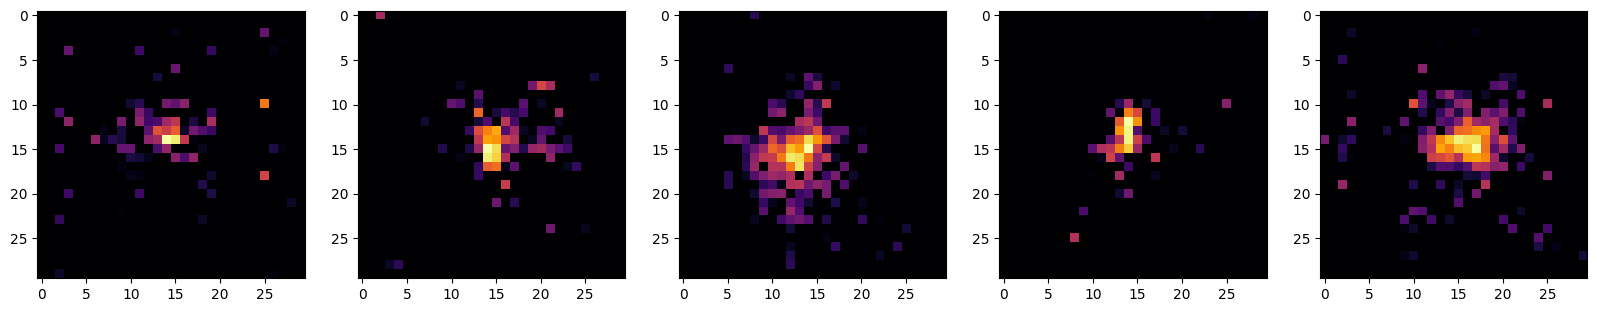

100%|██████████| 600/600 [00:45<00:00, 13.07it/s]


epochs done: 13


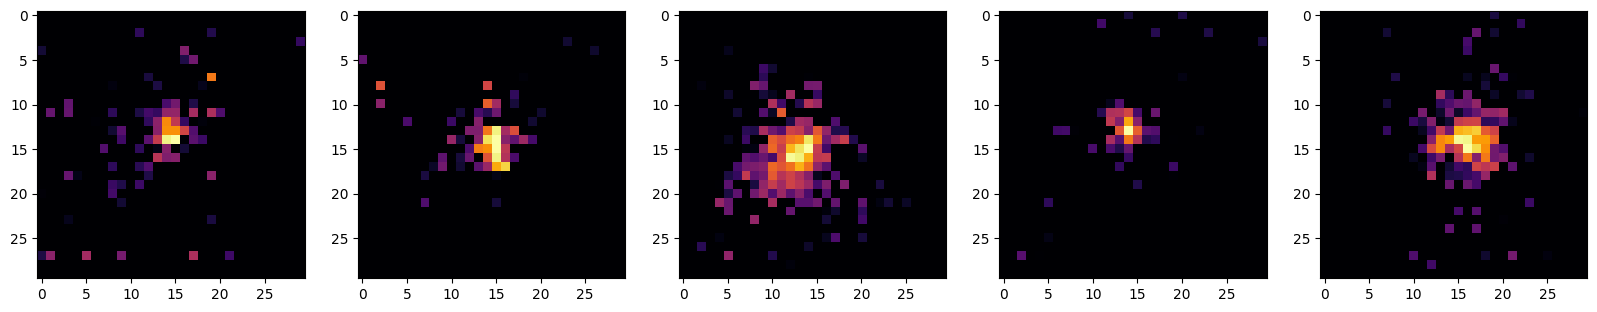

100%|██████████| 600/600 [00:45<00:00, 13.11it/s]


epochs done: 14


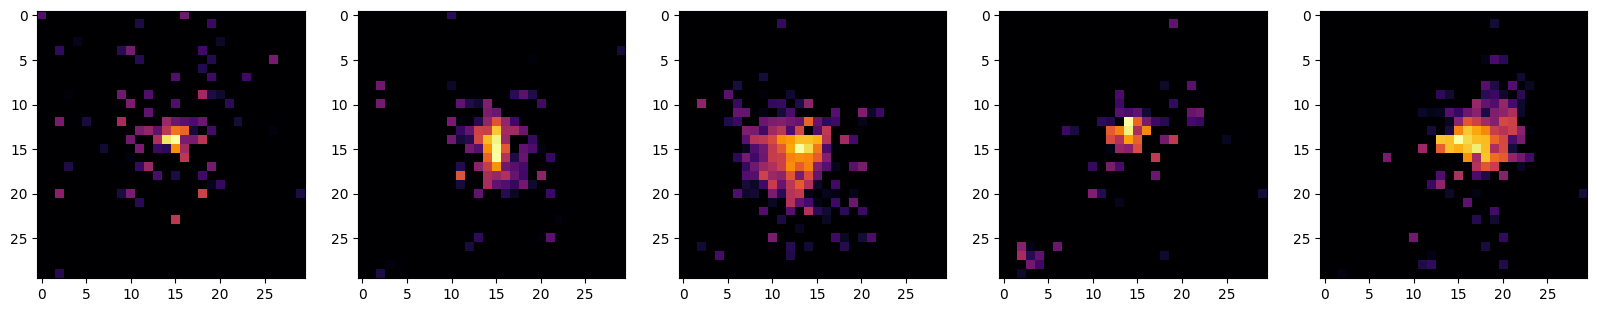

100%|██████████| 9/9 [01:33<00:00, 10.35s/it]


epochs done: 15


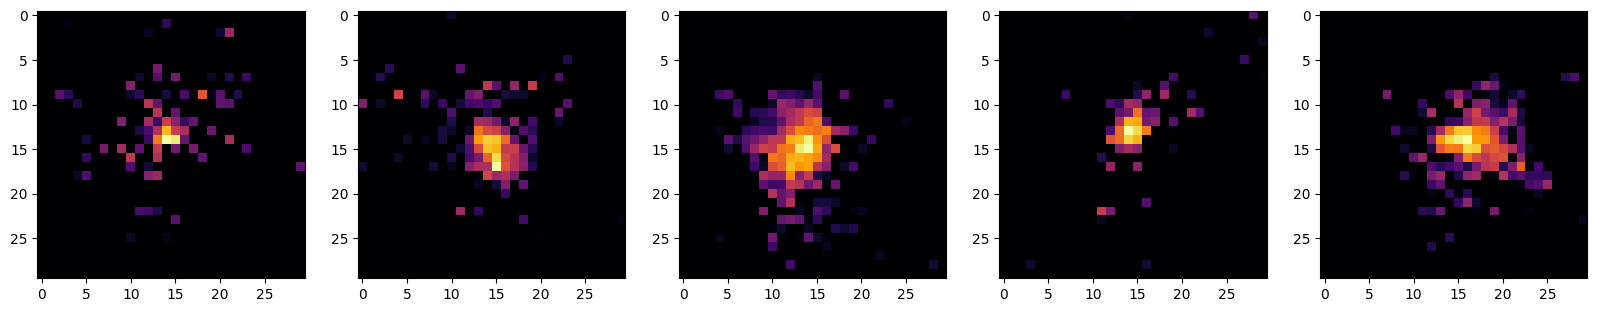

100%|██████████| 600/600 [00:46<00:00, 12.95it/s]


epochs done: 16


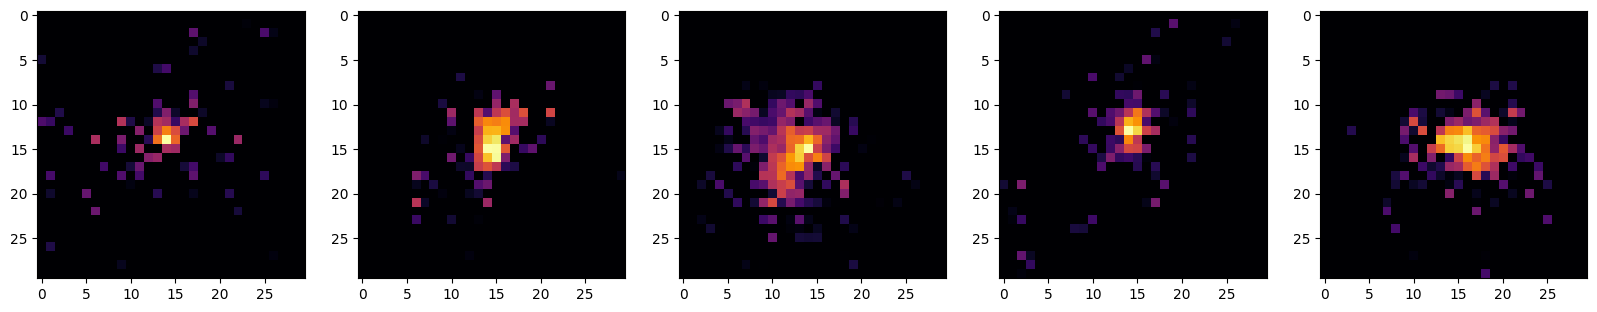

100%|██████████| 600/600 [00:46<00:00, 12.88it/s]


epochs done: 17


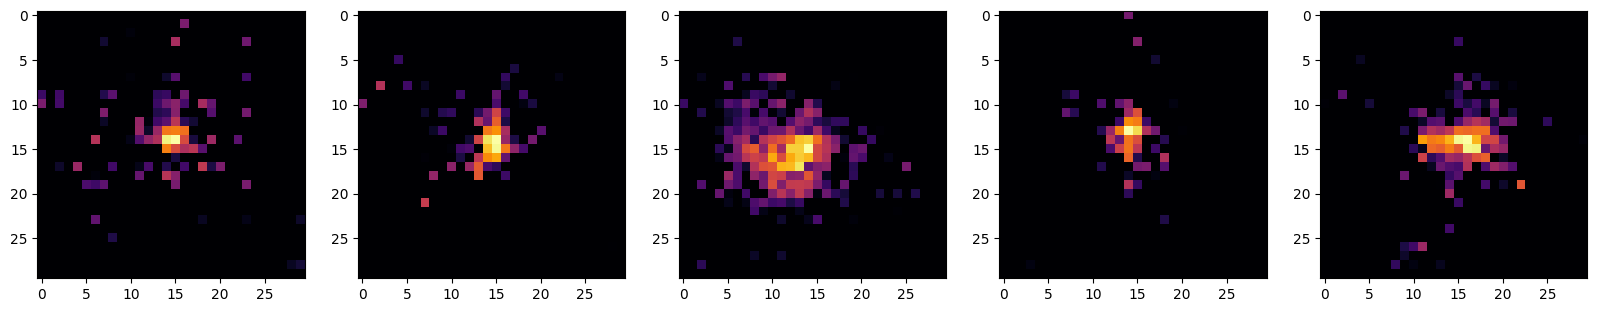

100%|██████████| 600/600 [00:46<00:00, 13.02it/s]


epochs done: 18


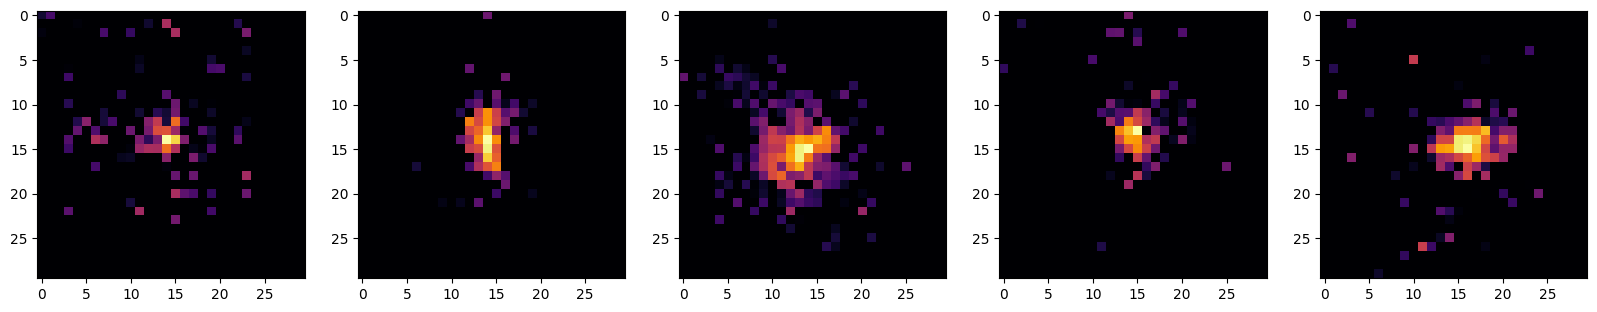

100%|██████████| 600/600 [00:46<00:00, 12.97it/s]


epochs done: 19


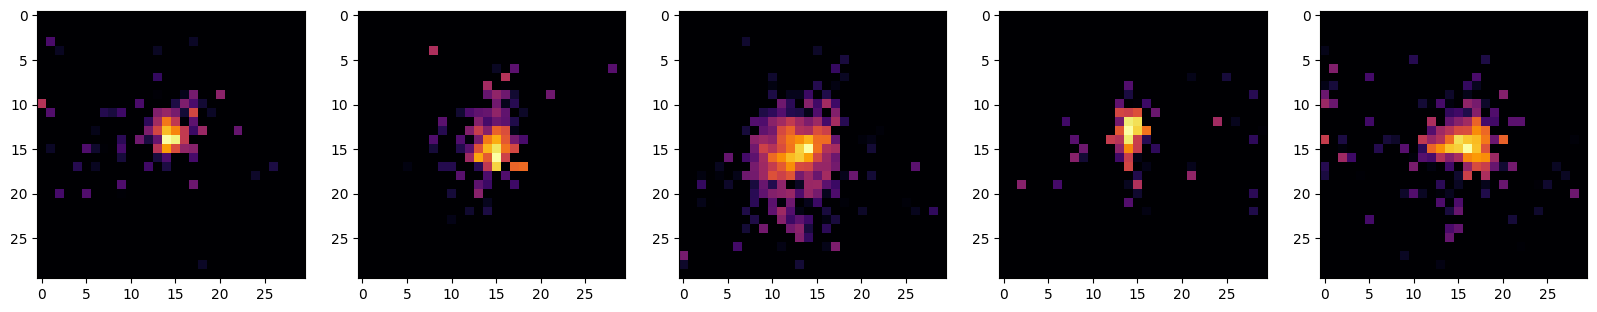

100%|██████████| 9/9 [01:30<00:00, 10.08s/it]


epochs done: 20


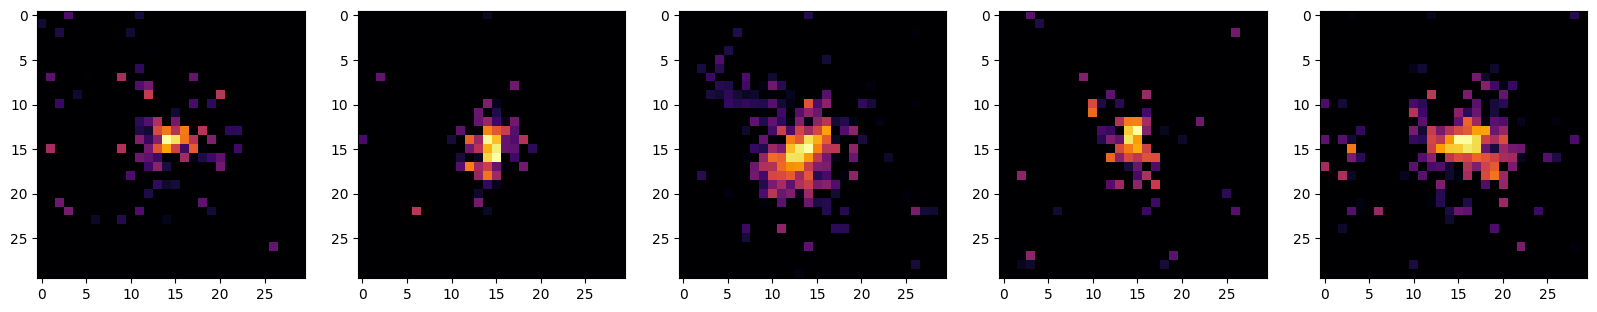

100%|██████████| 600/600 [00:45<00:00, 13.13it/s]


epochs done: 21


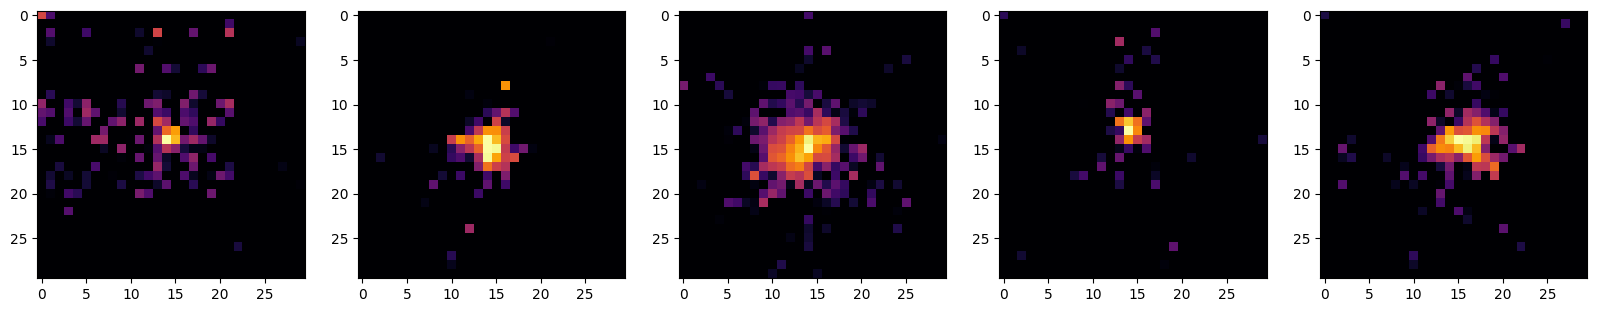

100%|██████████| 600/600 [00:45<00:00, 13.08it/s]


epochs done: 22


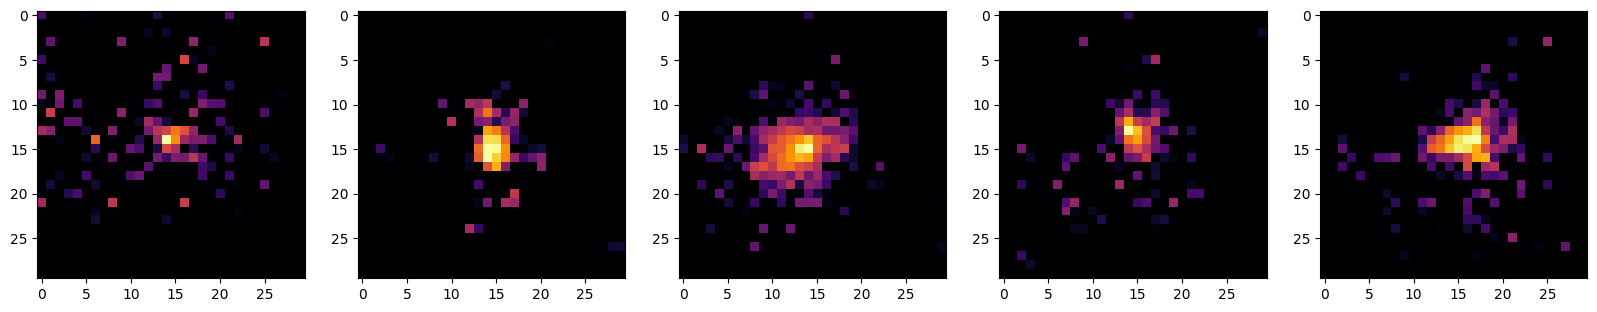

100%|██████████| 600/600 [00:45<00:00, 13.14it/s]


epochs done: 23


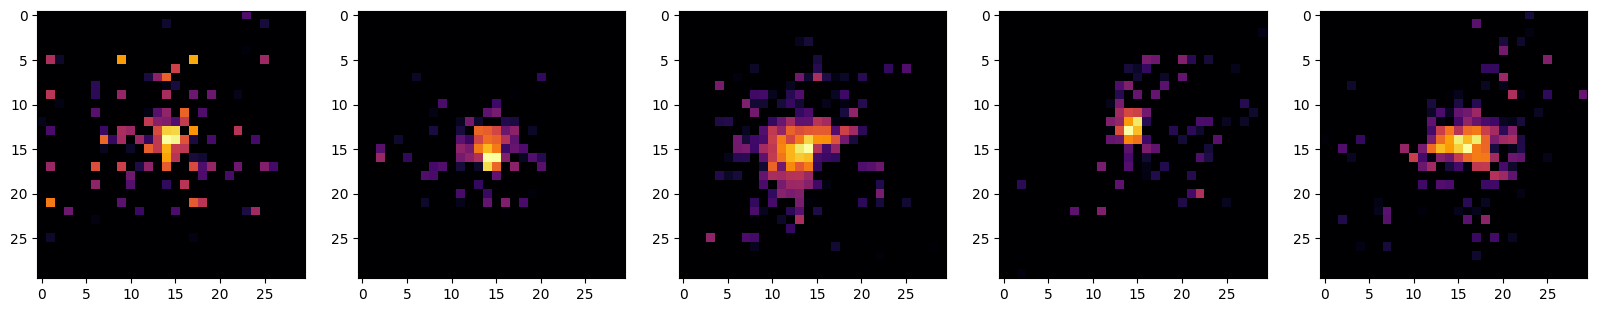

100%|██████████| 600/600 [00:45<00:00, 13.09it/s]


epochs done: 24


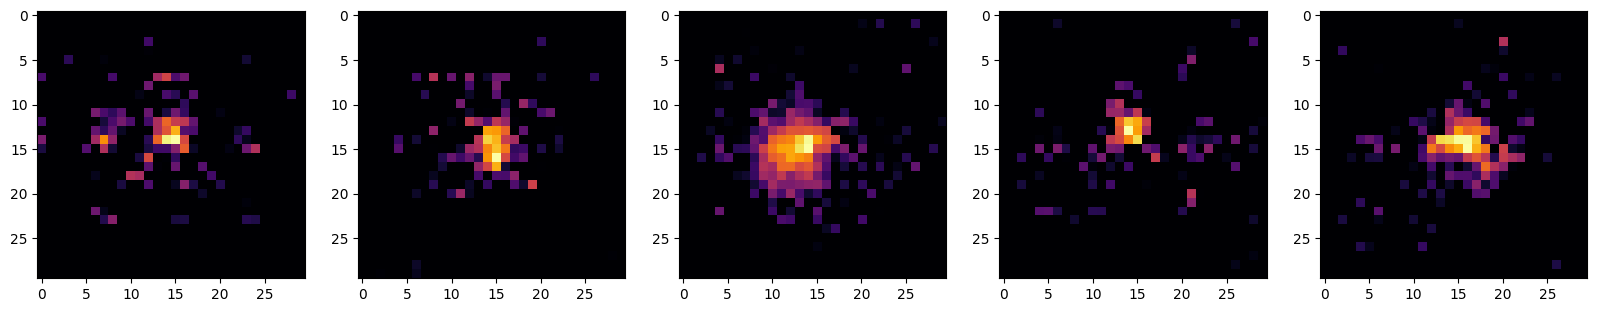

100%|██████████| 9/9 [01:31<00:00, 10.20s/it]


epochs done: 25


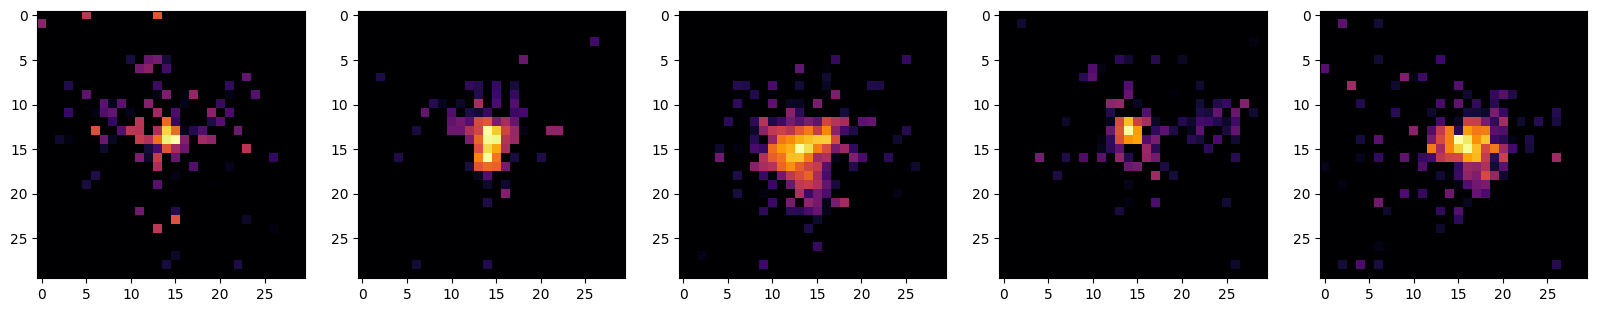

100%|██████████| 600/600 [00:46<00:00, 12.99it/s]


epochs done: 26


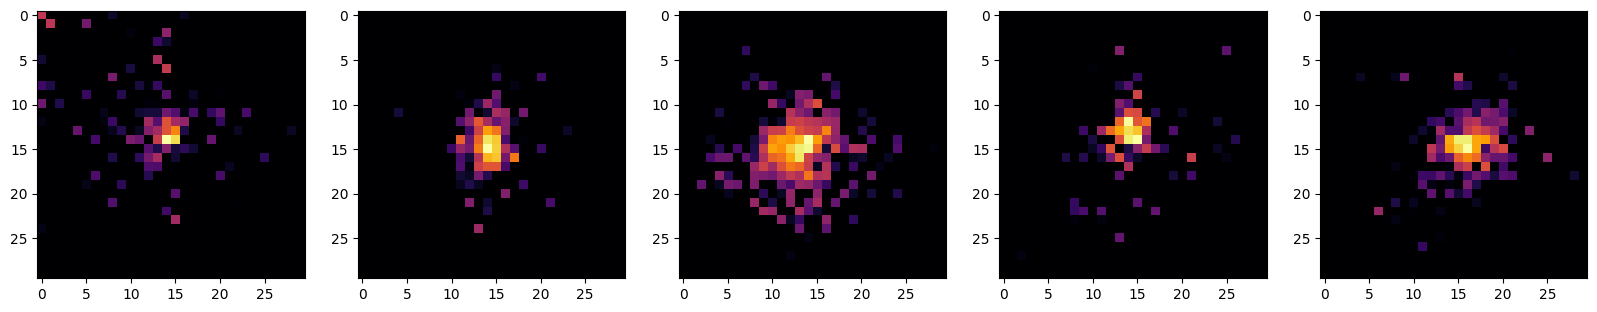

100%|██████████| 600/600 [00:45<00:00, 13.11it/s]


epochs done: 27


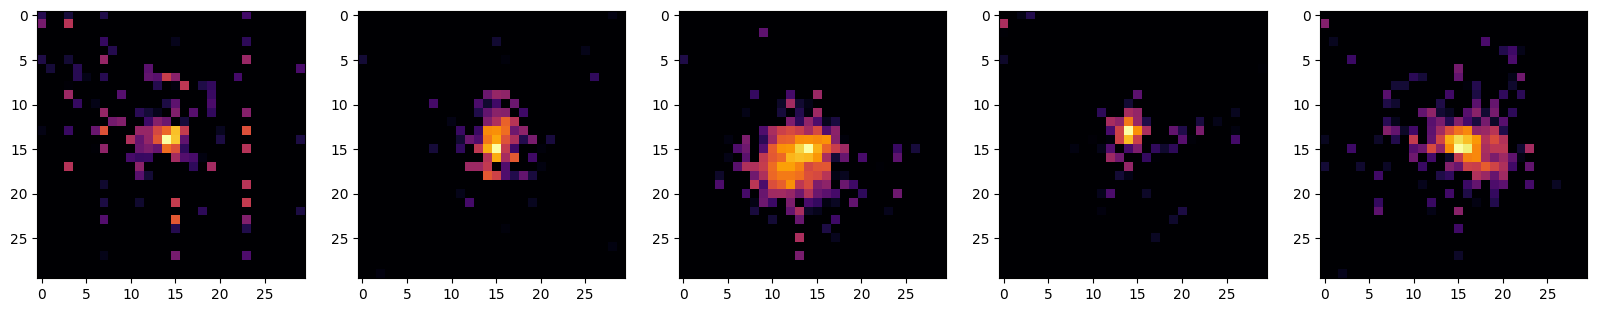

100%|██████████| 600/600 [00:45<00:00, 13.04it/s]


epochs done: 28


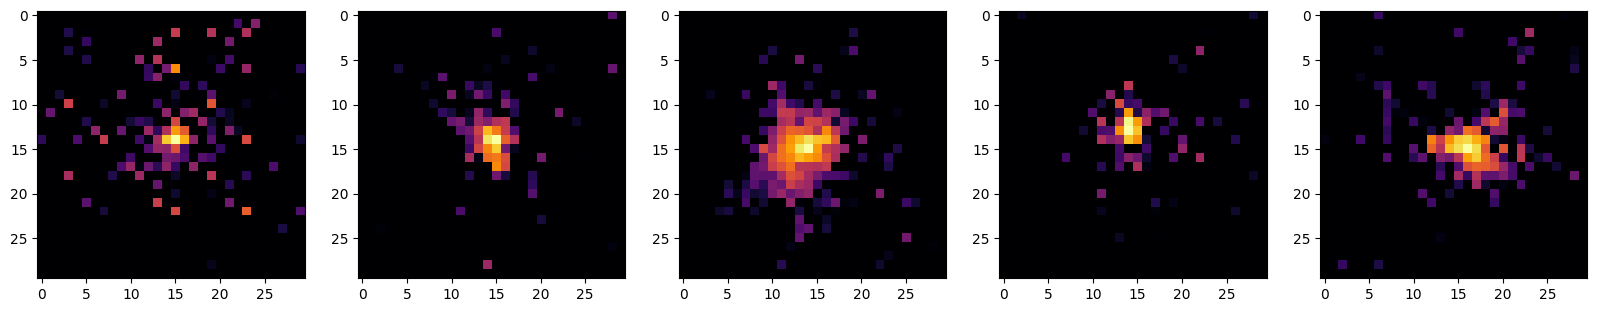

100%|██████████| 600/600 [00:45<00:00, 13.13it/s]


epochs done: 29


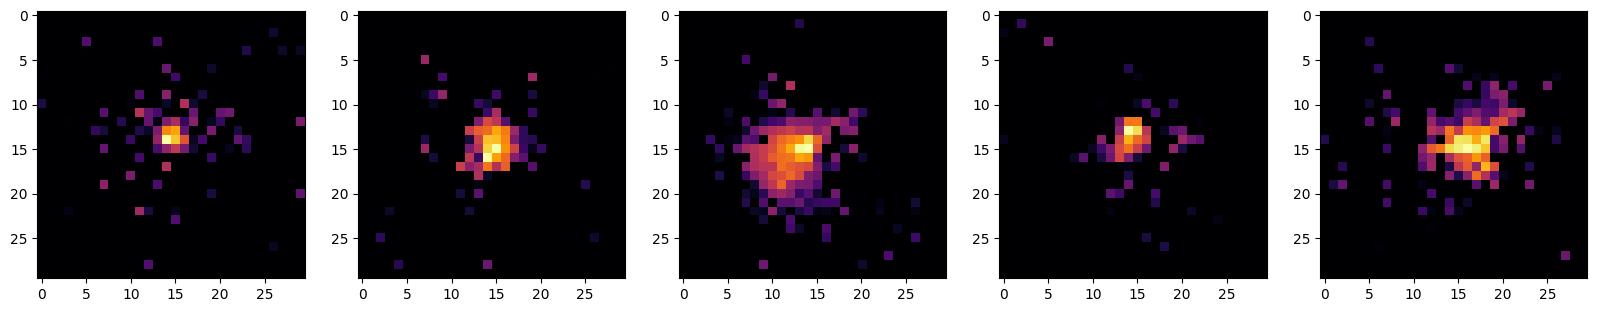

100%|██████████| 9/9 [01:30<00:00, 10.02s/it]


epochs done: 30


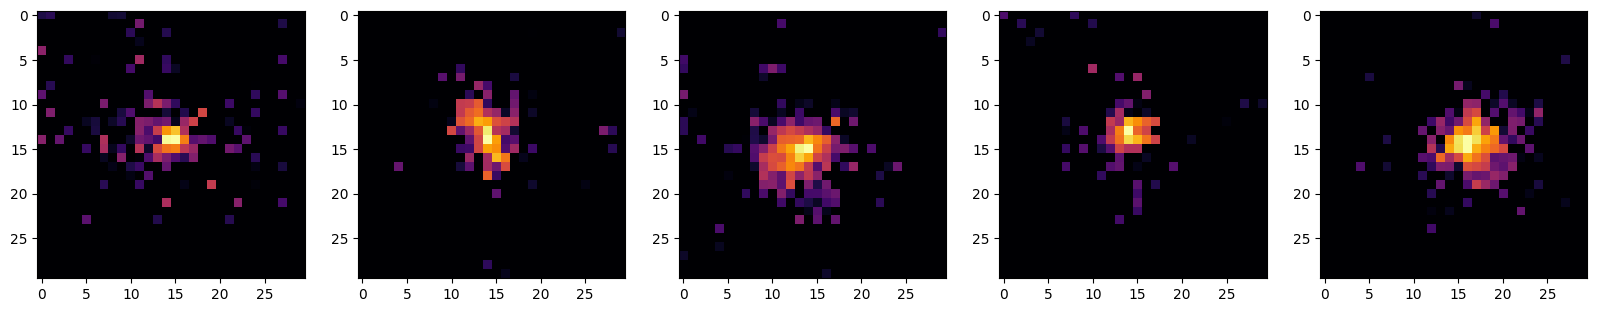

100%|██████████| 600/600 [00:45<00:00, 13.07it/s]


epochs done: 31


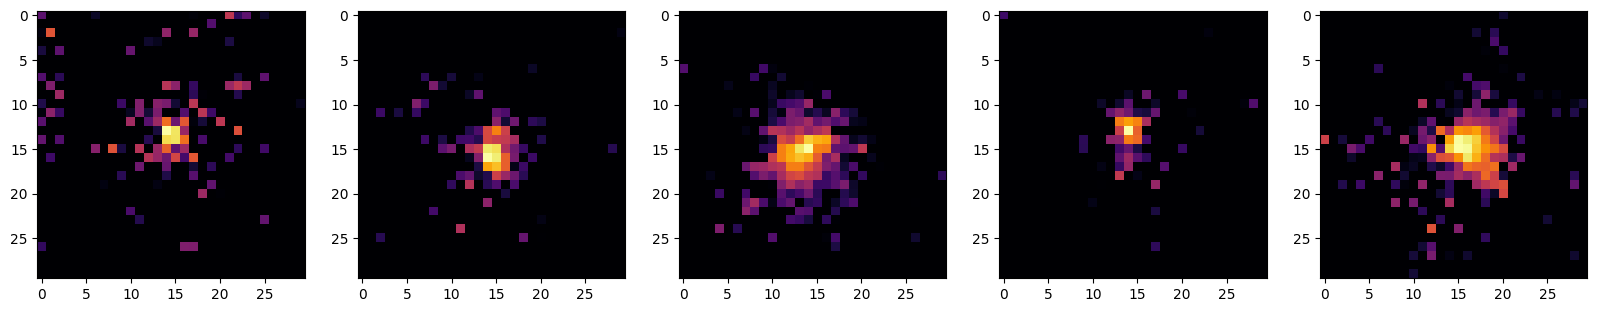

100%|██████████| 600/600 [00:45<00:00, 13.15it/s]


epochs done: 32


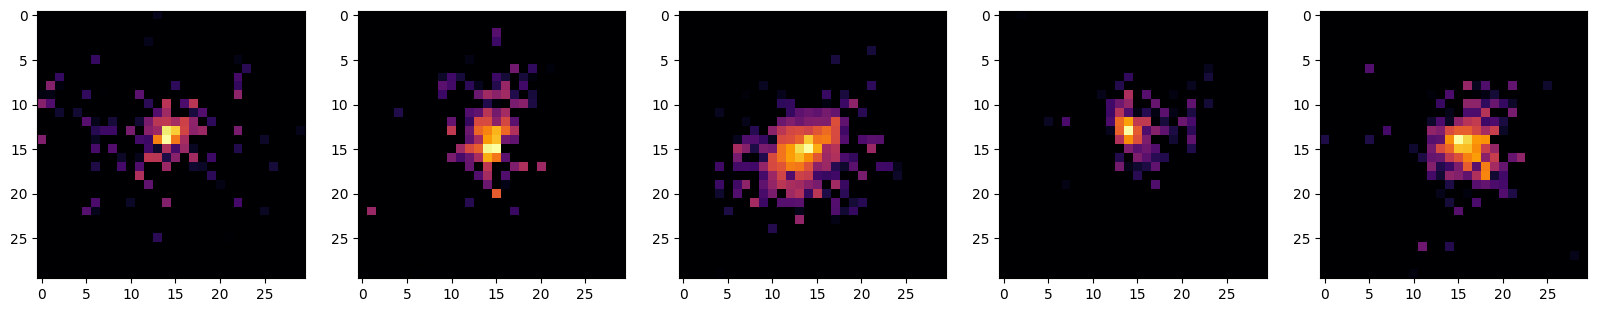

100%|██████████| 600/600 [00:45<00:00, 13.07it/s]


epochs done: 33


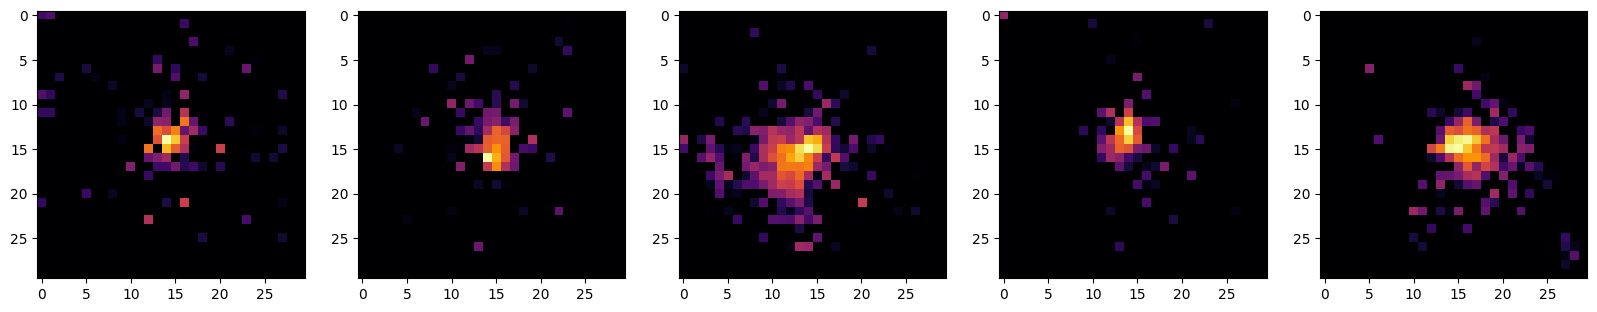

100%|██████████| 600/600 [00:45<00:00, 13.13it/s]


epochs done: 34


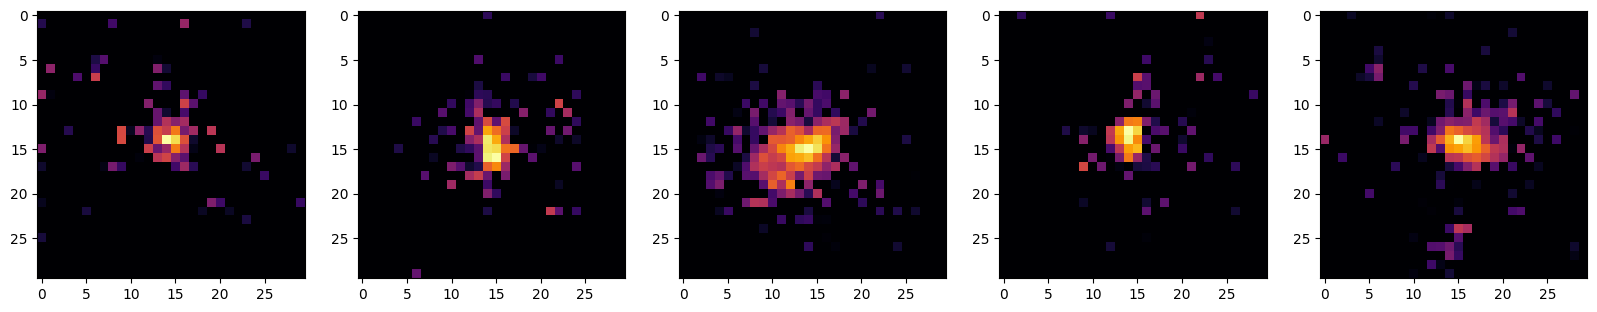

100%|██████████| 9/9 [01:31<00:00, 10.14s/it]


epochs done: 35


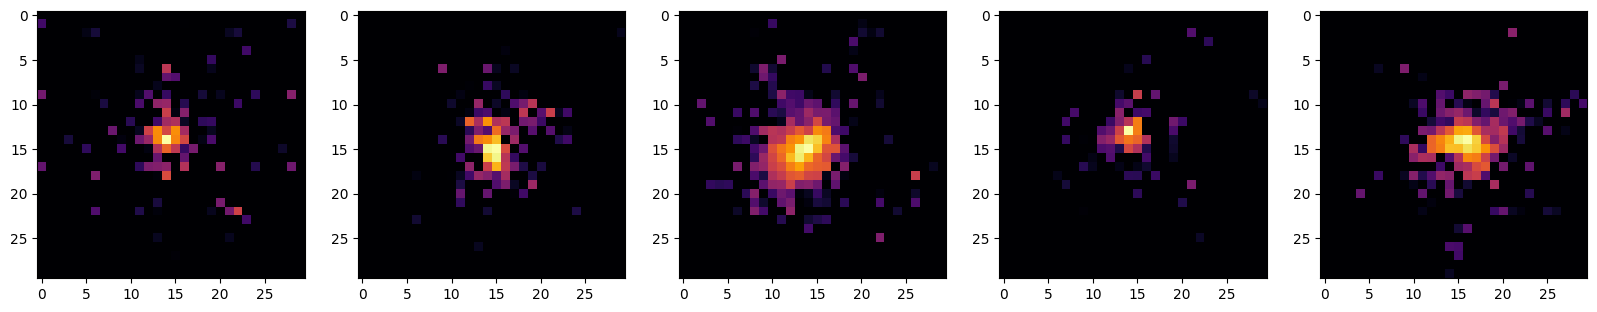

100%|██████████| 600/600 [00:45<00:00, 13.06it/s]


epochs done: 36


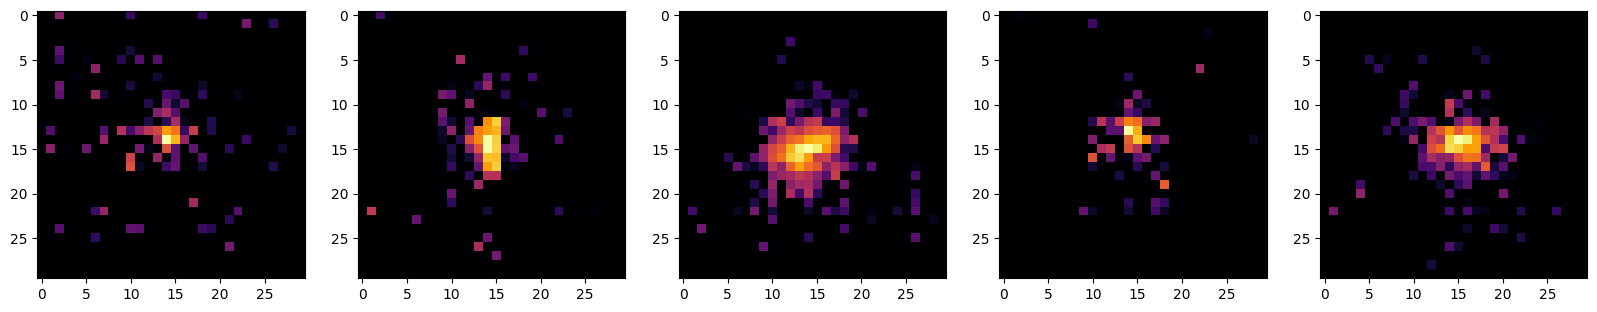

100%|██████████| 600/600 [00:45<00:00, 13.11it/s]


epochs done: 37


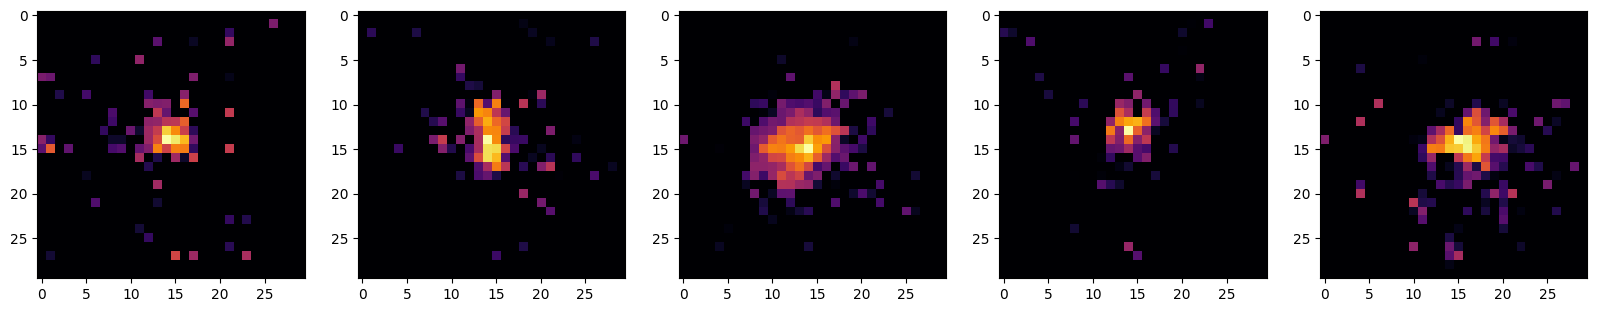

100%|██████████| 600/600 [00:46<00:00, 13.02it/s]


epochs done: 38


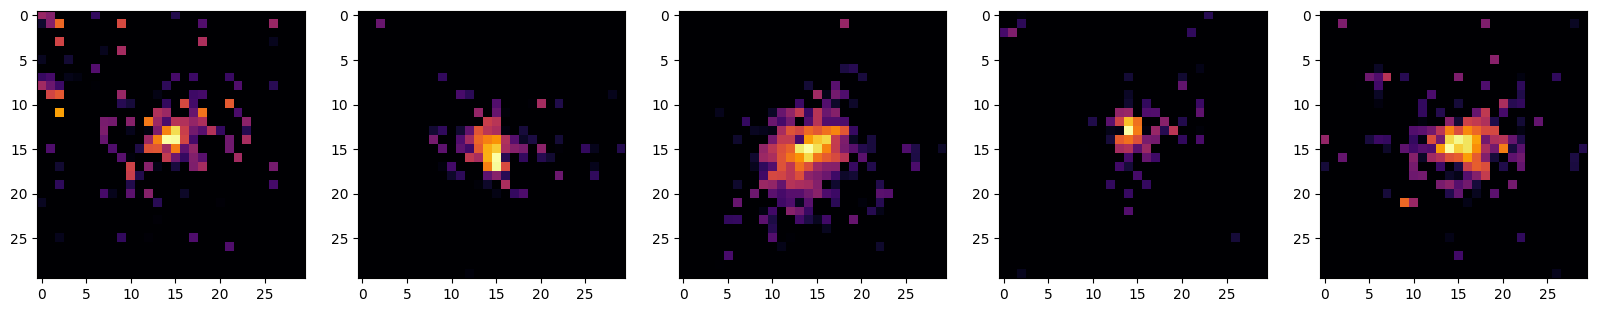

100%|██████████| 600/600 [00:46<00:00, 12.88it/s]


epochs done: 39


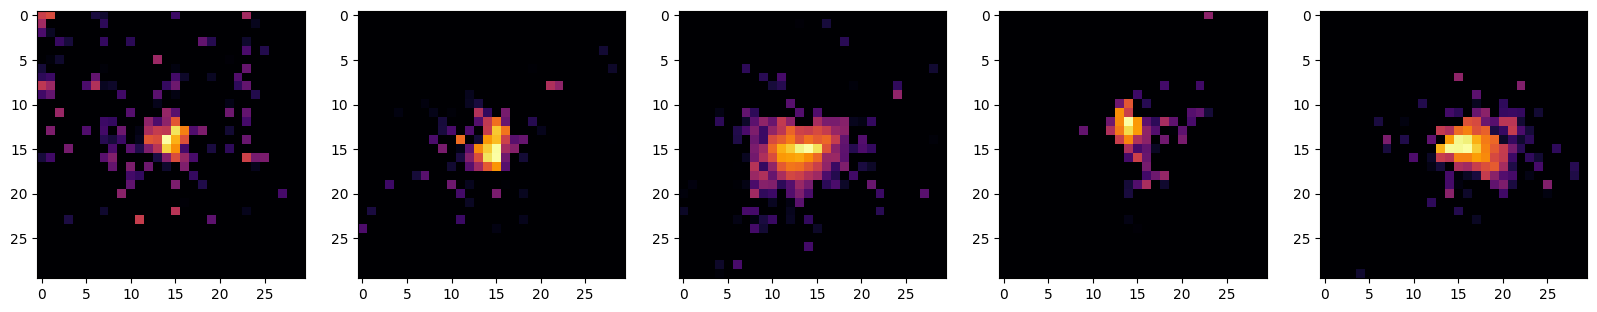

100%|██████████| 9/9 [01:30<00:00, 10.03s/it]


epochs done: 40


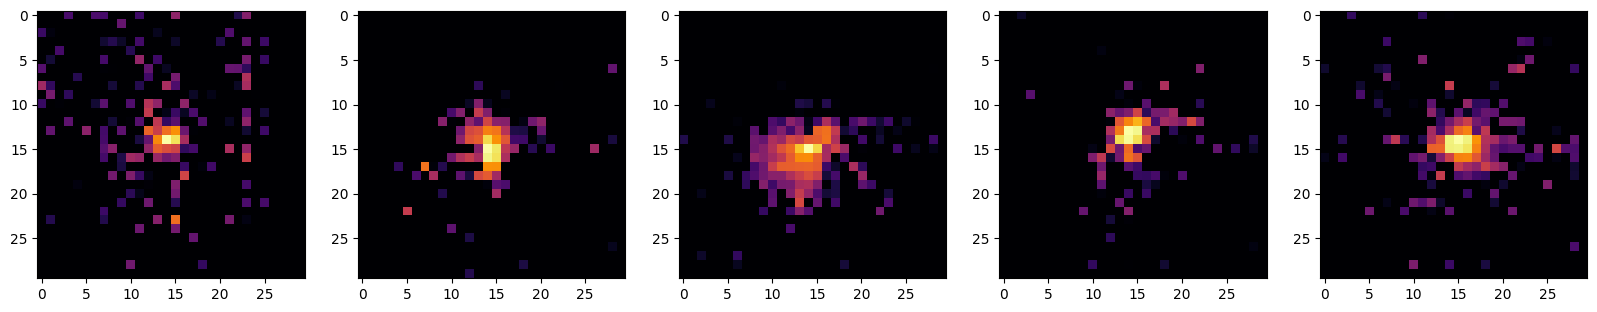

100%|██████████| 600/600 [00:45<00:00, 13.09it/s]


epochs done: 41


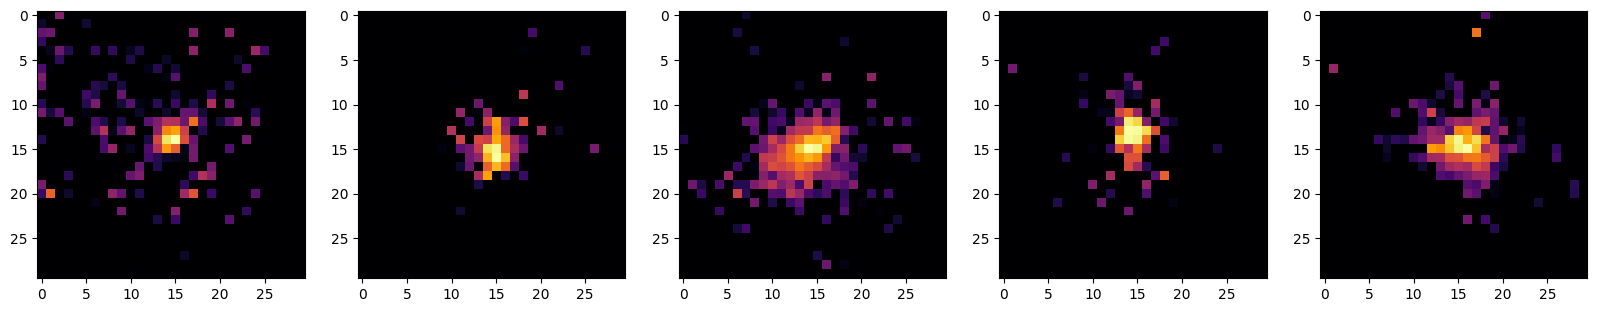

100%|██████████| 600/600 [00:46<00:00, 13.03it/s]


epochs done: 42


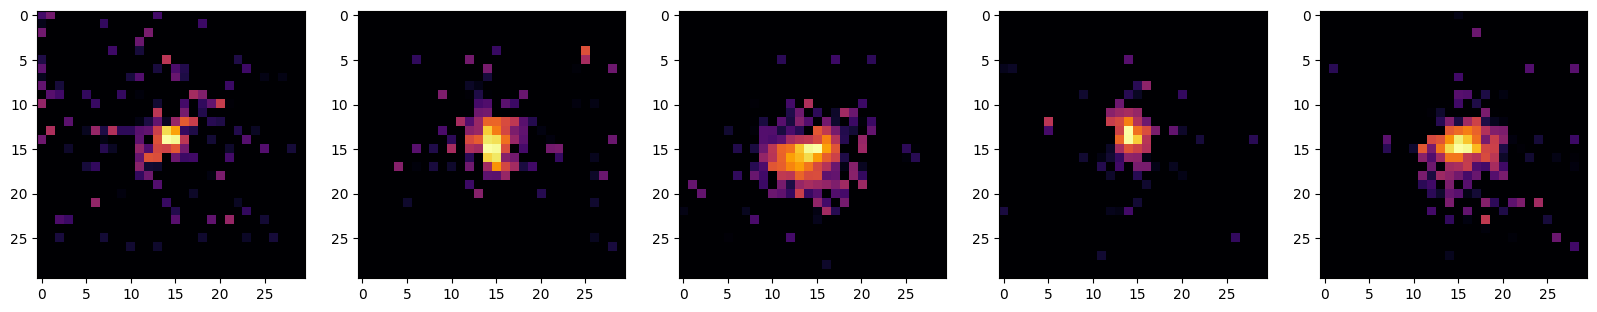

100%|██████████| 600/600 [00:46<00:00, 13.03it/s]


epochs done: 43


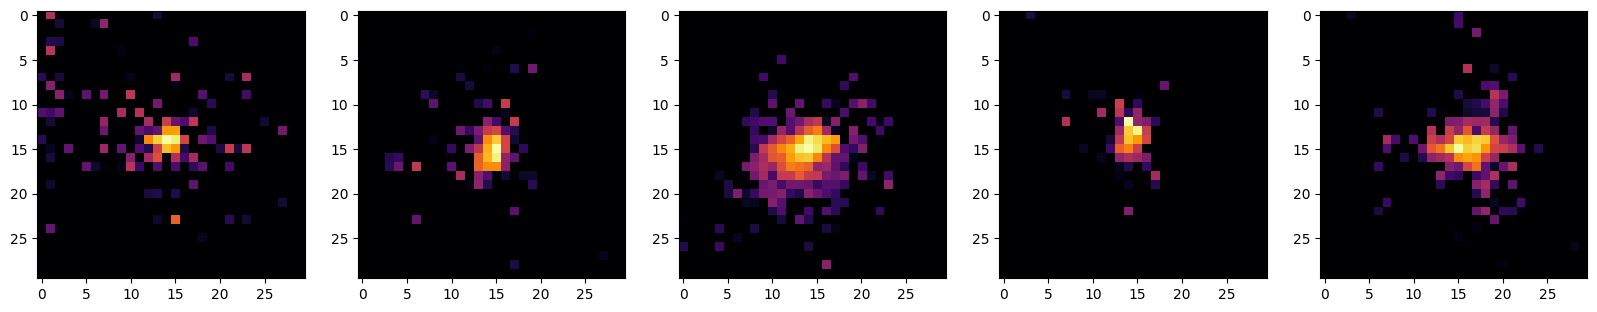

100%|██████████| 600/600 [00:45<00:00, 13.06it/s]


epochs done: 44


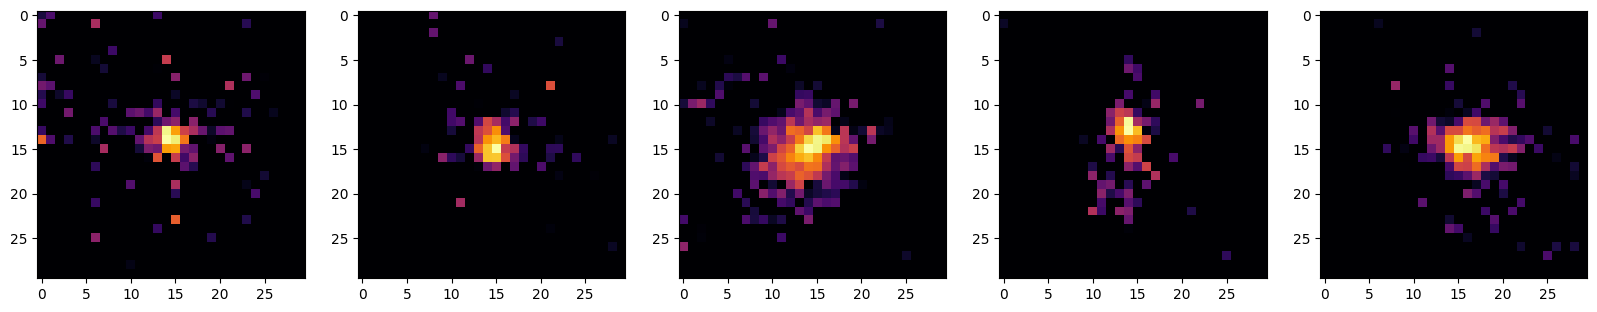

100%|██████████| 9/9 [01:34<00:00, 10.46s/it]


epochs done: 45


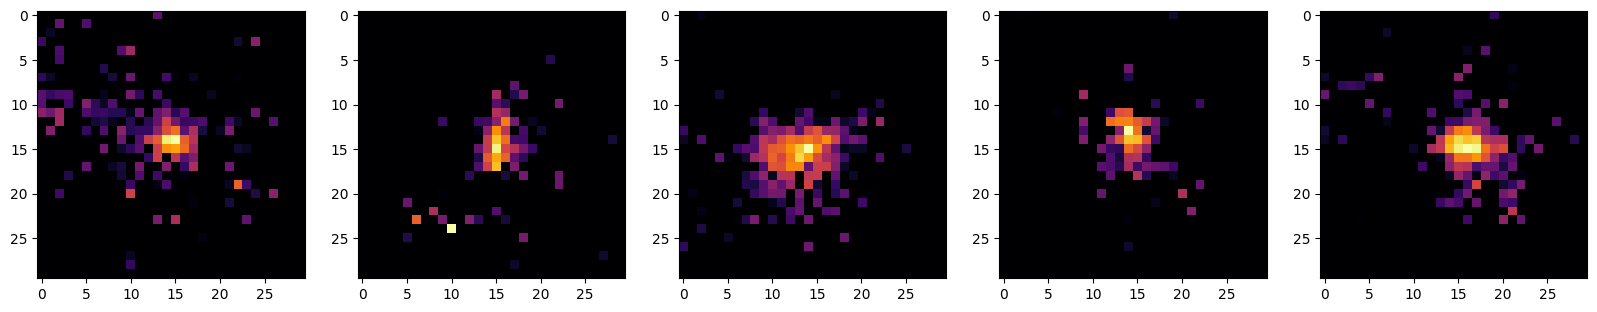

100%|██████████| 600/600 [00:46<00:00, 12.96it/s]


epochs done: 46


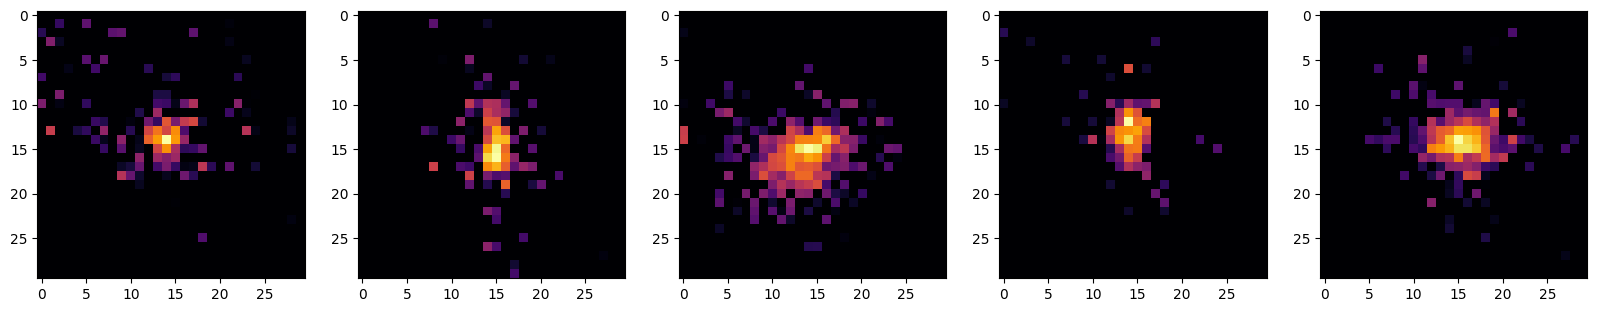

100%|██████████| 600/600 [00:45<00:00, 13.11it/s]


epochs done: 47


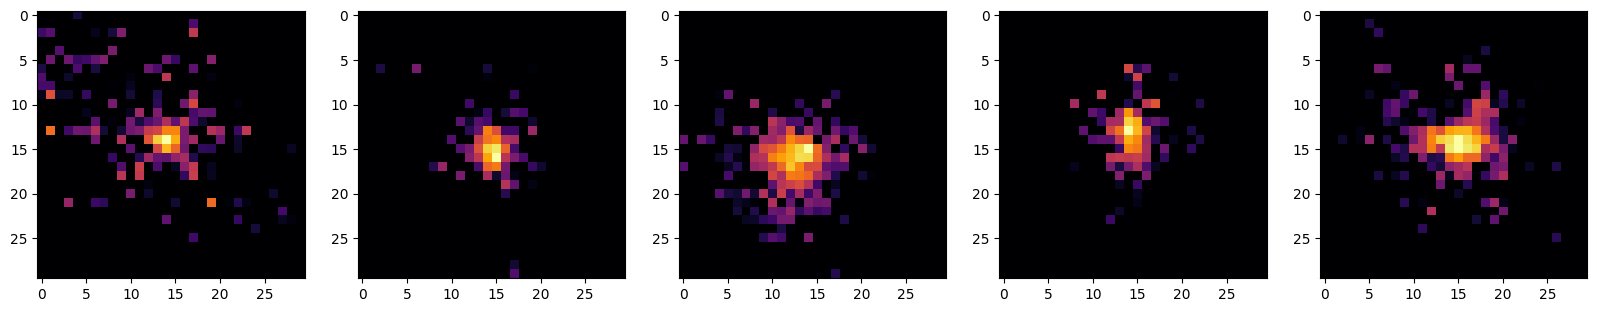

100%|██████████| 600/600 [00:45<00:00, 13.06it/s]


epochs done: 48


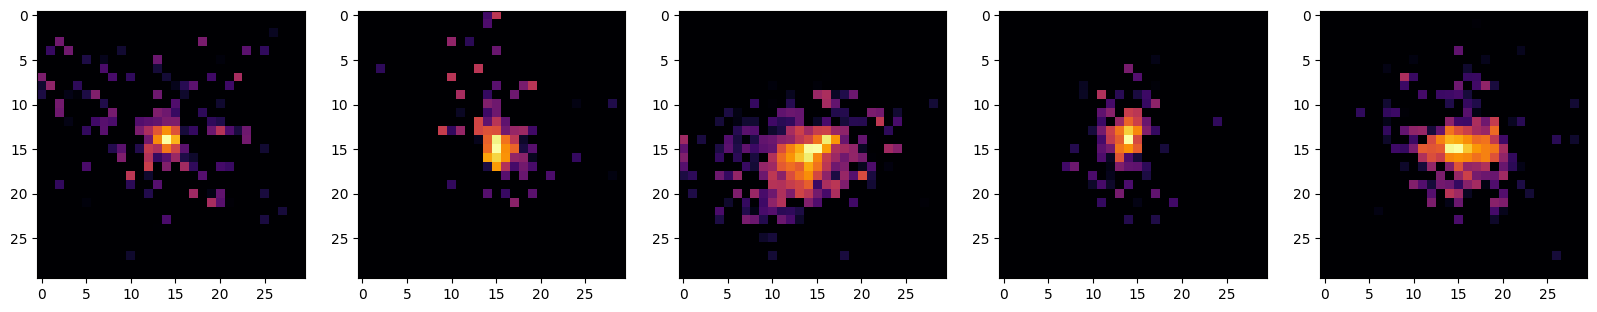

100%|██████████| 600/600 [00:45<00:00, 13.13it/s]


epochs done: 49


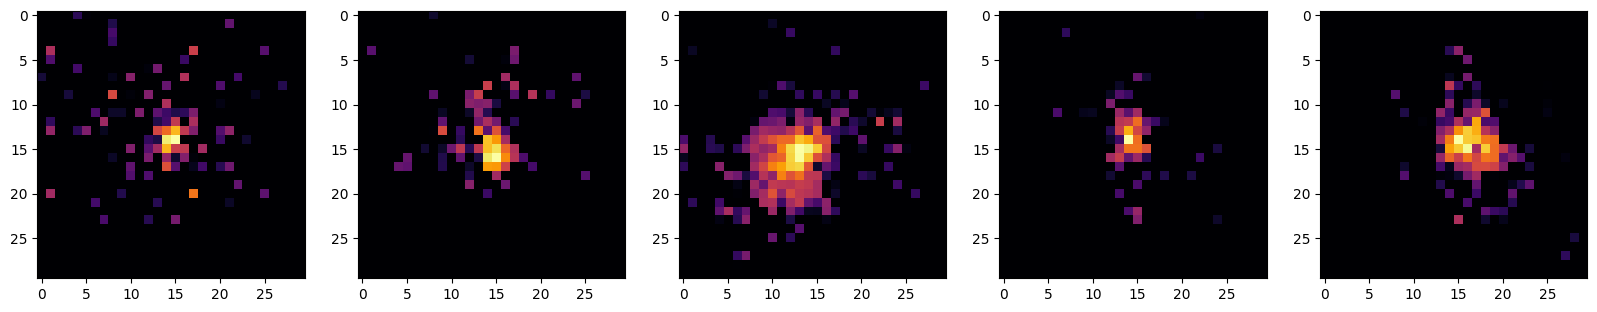

100%|██████████| 9/9 [01:29<00:00,  9.91s/it]


epochs done: 50


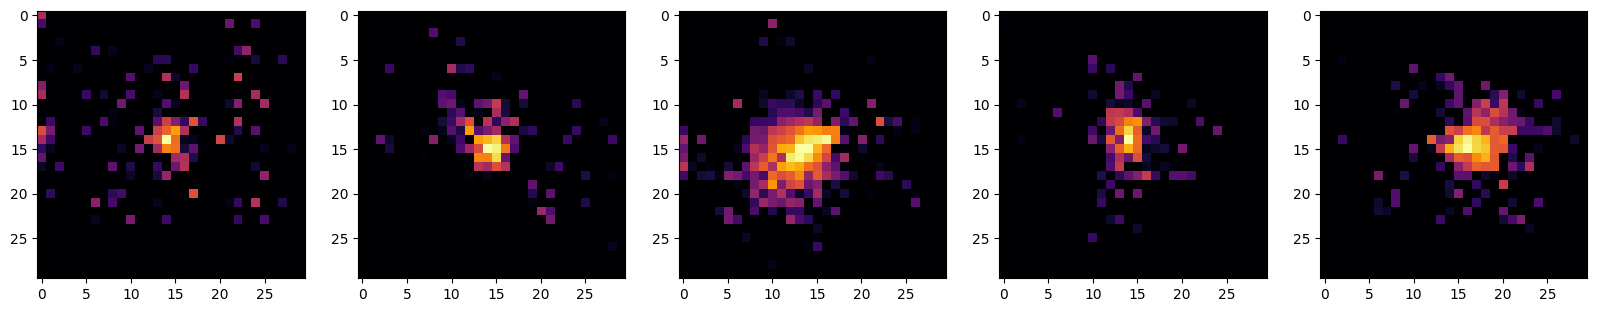

Energy PRD PR-AUC,▇▆▃▇▁▇▃▄█
PhysStats PRD PR-AUC,█▃▁▇▅▃▁▆▁
bin #0: Energy embed. Average PRD-AUC,▇▄▂▃█▅▁▇▄
bin #0: PhysStats Average PRD-AUC,█▁▄▂▇█▁██
bin #1: Energy embed. Average PRD-AUC,▂▅▅▇█▇▁█▇
bin #1: PhysStats Average PRD-AUC,▆▁▆█▇▄▅▆▇
bin #2: Energy embed. Average PRD-AUC,▆▅▄▅▆█▁█▇
bin #2: PhysStats Average PRD-AUC,▇▁▅█▃▅▇▇▄
bin #3: Energy embed. Average PRD-AUC,█▅▂▄▁▇▅▆▆
bin #3: PhysStats Average PRD-AUC,█▅▃▃▁▇▅▇▄
bin #4: Energy embed. Average PRD-AUC,█▇▅▆▁▇▆▃█


In [19]:
for epoch, gan in gan_trainer:
    print(f'epochs done: {epoch-1}')
    gen_several_images(gan, len(visualization_data[0]), y=visualization_data[1:], figsize=(20, 11), imshow_fn=energy_imshow)